<a href="https://colab.research.google.com/github/chacha715/ESAA/blob/main/%ED%8F%89%EA%B0%80.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **03 평가**
## **01. 정확도(Accuracy)**

: 정확도(Accuracy) = 예측 결과가 동일한 데이터 건수 / 전체 예측 데이터 건수
*   단순한 알고리즘으로 예측을 하더라도 데이터의 구성에 따라 정확도 결과가 높은 수치로 나올 수 있기에 정확도를 평가 지표로 사용할 때는 매우 신중해야 함.
*   특히 정확도는 불균형한(imbalanced) 레이블 값 분포에서 ML 모델의 성능을 판단할 경우, 적합한 평가 지표가 아님. 여러 가지 분료 지표와 함께 적용.



In [1]:
from sklearn.base import BaseEstimator

class MyDummyClassifier(BaseEstimator):
  #fit() 메서드는 아무것도 학습하지 않음
  def fit( self, X, y=None):
    pass
  #predict() 메서드는 단순히 Sex 피쳐가 1이면 0, 그렇지 않으면 1로 예측함
  def predict(self, X):
    pred=np.zeros((X.shape[0],1))
    for i in range( X.shape[0]):
      if X['Sex'].iloc[i]==1:
        pred[i]=0
      else: pred[i]=1

    return pred

In [8]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import LabelEncoder

##(추가)
## Null 처리 함수
def fillna(df):
    df['Age'].fillna(df['Age'].mean(), inplace=True)
    df['Cabin'].fillna('N', inplace=True)
    df['Embarked'].fillna('N', inplace=True)
    df['Fare'].fillna(0, inplace=True)
    return df

## 머신러닝에 불필요한 피처 제거
def drop_features(df):
    df.drop(['PassengerId', 'Name', 'Ticket'], axis=1, inplace=True)
    return df

## Label Encoding 수행
def format_features(df):
    df['Cabin'] = df['Cabin'].str[:1]
    features = ['Cabin', 'Sex', 'Embarked']
    for feature in features:
        le = LabelEncoder()
        le.fit(df[feature])
        df[feature] = le.transform(df[feature])
    return df
##

## 앞에서 실행한 Data Preprocessing 함수 호출
def transform_features(df):
    df = fillna(df)
    df = drop_features(df)
    df = format_features(df)
    return df

#원본 데이터를 재로딩, 데이터 가공, 학습 데이터/테스트 데이터 분할
from google.colab import drive
drive.mount('/content/drive')
titanic_df=pd.read_csv('/content/drive/MyDrive/ESAA/DATA/titanic_train.csv')
y_titanic_df=titanic_df['Survived']
X_titanic_df=titanic_df.drop('Survived',axis=1)
X_titanic_df=transform_features(X_titanic_df)
X_train,X_test,y_train,y_test=train_test_split(X_titanic_df,y_titanic_df,test_size=0.2,random_state=0)

#위에서 생성한 Dummy Classifier을 이용해 학습/예측/평가 수행
myclf=MyDummyClassifier()
myclf.fit(X_train,y_train)
mypredictions=myclf.predict(X_test)
print("Dummy Classifier의 정확도는 : {0:.4f}".format(accuracy_score(y_test,mypredictions)))

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Dummy Classifier의 정확도는 : 0.7877


In [9]:
from sklearn.datasets import load_digits
from sklearn.model_selection import train_test_split
from sklearn.base import BaseEstimator
from sklearn.metrics import accuracy_score
import numpy as np
import pandas as pd


class MyFakeClassifier(BaseEstimator):
  def fit(self,X,y):
    pass

  #입력값으로 들어오는 X 데이터 세트의 크기만큼 모두 0값으로 만들어서 반환
  def predict(self,X):
    return np.zeros((len(X),1),dtype=bool) 

  #사이킷런의 내장 데이터 세트인 load_digits()을 이용해 MNIST 데이터 로딩
digits=load_digits()

 #digits 번호가 7번이면 True 이고 이를 astype(int)로 1로 변환, 7번이 아니면 False이고 0으로 변환
y=(digits.target==7).astype(int)
X_train,X_test,y_train,y_test=train_test_split(digits.data,y,random_state=11)

In [10]:
#불균형한 레이블 데이터 분포도 확인
print('레이블 테스트 세트 크기:',y_test.shape)
print('테스트 세트 레이블 0과 1의 분포도')
print(pd.Series(y_test).value_counts())

#Dummy Classifier로 학습/예측/정확도 평가
fakeclf=MyFakeClassifier()
fakeclf.fit(X_train,y_train)
fakepred=fakeclf.predict(X_test)
print('모든 예측을 0으로 하여도 정확도는:{:.3f}'.format(accuracy_score(y_test,fakepred)))

레이블 테스트 세트 크기: (450,)
테스트 세트 레이블 0과 1의 분포도
0    405
1     45
dtype: int64
모든 예측을 0으로 하여도 정확도는:0.900



---
##**02. 오차 행렬**

*   오차행렬(confusion matrix)은 학습된 분류 모델이 예측을 수행하면서 얼마나 헷갈리고 있는지도 함께 보여주는 지표. 예측 오류가 얼마인지와 더불어 어떠한 유형의 예측 오류가 발생하고 있는지를 함께 나타냄.
*   True는 예측 클래스 값과 실제 클래스 값이 같다는 의미, Negative는 예측값이 Negative 값이라는 의미.
*   사이킷런은 오차 행렬을 구하기 위해 confusion_matrix() API를 제공
*   정확도는 예측값과 실제 값이 얼마나 동일한가에 대한 비율만으로, TN과 TP에 좌우됨. 정확도 지표는 비대칭한 데이터 세트에서 Positive에 대한 예측 정확도를 판단하지 못한 채 Negative에 대한 예측 정확도만으로도 분류의 정확도가 매우 높게 나타나는 수치적인 판단 오류를 일으킴.






In [11]:
from sklearn.metrics import confusion_matrix

confusion_matrix(y_test,fakepred)

array([[405,   0],
       [ 45,   0]])


---
##**03. 정밀도와 재현율**

*   정밀도와 재현율은 Positive 데이터 세트의 예측 성능에 좀 더 초점을 맞춘 평가 지표
*   정밀도 = TP / (FP+TP), 재현율 = TP / (FN+TP)
*   정밀도는 Positive 예측 성능을 더욱 정밀하게 측정하기 위한 평가 지표로 양성 예측도라고도 불림
*   재현율은 민감도(Sensitivity) 또는 TPR라고도 불림
*   **재현율이 중요 지표인 경우는 실제 Positive 양성 데이터를 Negative로 잘못 판단하게 되면 업무상 큰 영향이 발생하는 경우**
*   재현율과 정밀도 모두 TP를 높이는 데 동일하게 초점을 맞추지만, 재현율은 FN을 낮추는 데, 정밀도는 FP를 낮추는 데 초점을 맞춤. 재현율과 정밀도는 서로 보완적인 지표로 분류의 성능을 평가하는 데 적용됨.
*   사이킷런은 정밀도 계산을 위해 precision_score()를, 재현율 계산을 위해 recall_score()를 API로 제공.


###**정밀도/재현율 트레이드오프**

*   분류하려는 업무의 특성상 정밀도 또는 재현율이 특별히 강조돼야 할 경우 분류의 결정 임곗값(Threshold)을 조정해 정밀도 또는 재현율의 수치를 높일 수 있음. 하지만 정밀도와 재현율은 상호 보완적인 평가 지표이기에 어느 한쪽을 강제로 높이면 다른 하나의 수치는 떨어지기 쉬움. 이를 정밀도/재현율의 트레이드오프(Trade-off)라고 부름.
*   사이킷런은 개별 데이터별로 예측 확률을 반환하는 메서드인 predict_proba()를 제공. predict()는 predict_proba() 호출 결과로 반환된 배열에서 분류 결정 임계값보다 큰 값이 들어 있는 칼럼의 위치를 받아서 최종적으로 예측 클래스를 결정하는 API.

*   Positive 예측값이 많아지면 상대적으로 재현율 값이 높아짐.
*   사이킷런은 임계값 변화에 따른 평가 지표 값을 알아보는 코드와 유사한 precision_recall_curve() API를 제공. 이는 정밀도와 재현율의 임곗값에 따른 값 변화를 곡선 형태의 그래프로 시각화하는 데 이용 가능. 임계값이 낮을수록 많은 수의 양성 예측으로 인해 재현율 값이 극도로 높아지고 정밀도 값이 극도로 낮아짐. 임계값을 계속 증가시킬수록 반대의 양상.



###**정밀도와 재현율의 맹점**

*   **정밀도가 100%가 되는 방법**
: 확실한 기준이 되는 경우만 Positive로 예측하고 나머지는 모두 Negative로 예측
*   **재현율이 100%가 되는 방법**
: 모든 환자를 Positive로 예측





In [12]:
from sklearn.metrics import accuracy_score,precision_score,precision_score,recall_score,confusion_matrix

def get_clf_eval(y_test,pred):
  confusion=confusion_matrix(y_test,pred)
  accuracy=accuracy_score(y_test,pred)
  precision=precision_score(y_test,pred)
  recall=recall_score(y_test,pred)
  print('오차 행렬')
  print(confusion)
  print('정확도:{0:.4f},정밀도:{1:.4f},재현율:{2:.4f}'.format(accuracy,precision,recall))

In [14]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression

#원본 데이터를 재로딩, 데이터 가공, 학습 데이터/테스트 데이터 분할
titanic_df=pd.read_csv('/content/drive/MyDrive/ESAA/DATA/titanic_train.csv')
y_titanic_df=titanic_df['Survived']
X_titanic_df=titanic_df.drop('Survived',axis=1)
X_titanic_df=transform_features(X_titanic_df)

X_train,X_test,y_train,y_test=train_test_split(X_titanic_df,y_titanic_df,test_size=0.20,random_state=11)

lr_clf=LogisticRegression()

lr_clf.fit(X_train,y_train)
pred=lr_clf.predict(X_test)
get_clf_eval(y_test,pred)

오차 행렬
[[104  14]
 [ 13  48]]
정확도:0.8492,정밀도:0.7742,재현율:0.7869


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,


In [16]:
pred_proba=lr_clf.predict_proba(X_test)
pred=lr_clf.predict(X_test)
print('pred_proba() 결과 Shape:{0}'.format(pred_proba.shape))
print('pred_proba() array에서 앞 3개만 샘플로 추출 \n:',pred_proba[:3])

#예측 확률 array와 예측 결괏값 array를 병합(concatenate)해 예측 확률과 결괏값을 한 눈에 확인
pred_proba_result=np.concatenate([pred_proba,pred.reshape(-1,1)],axis=1)
print('두 개의 class 중에서 더 큰 확률을 클래스 값으로 예측  \n',pred_proba_result[:3])

pred_proba() 결과 Shape:(179, 2)
pred_proba() array에서 앞 3개만 샘플로 추출 
: [[0.46191519 0.53808481]
 [0.878675   0.121325  ]
 [0.87716185 0.12283815]]
두 개의 class 중에서 더 큰 확률을 클래스 값으로 예측  
 [[0.46191519 0.53808481 1.        ]
 [0.878675   0.121325   0.        ]
 [0.87716185 0.12283815 0.        ]]


In [17]:
from sklearn.preprocessing import Binarizer

X=[[1,-1,2],
   [2,0,0],
   [0,1.1,1.2]]

#X의 개별 원소들이  threshold값보다 같거나 작으면 0을 크면 1을 반환
binarizer=Binarizer(threshold=1.1)
print(binarizer.fit_transform(X))

[[0. 0. 1.]
 [1. 0. 0.]
 [0. 0. 1.]]


In [18]:
from sklearn.preprocessing import Binarizer

#Binarizer의 threshold 설정값, 분류 결정 임계값임
custom_threshold=0.5

#predict_proba() 반환값의 두번째 칼럼, 즉 positvie 클래스 칼럼 하나만 추출해 Binarizer 적용
pred_proba_1=pred_proba[:,1].reshape(-1,1)


binarizer=Binarizer(threshold=custom_threshold).fit(pred_proba_1)
custom_predict=binarizer.transform(pred_proba_1)


get_clf_eval(y_test,custom_predict)

오차 행렬
[[104  14]
 [ 13  48]]
정확도:0.8492,정밀도:0.7742,재현율:0.7869


In [19]:
#Binarizer의 threshold 설정값을 0.4로 설정. 즉 분류 결정 임곗값을 0.5에서 0.4로 낮춤
custom_threshold=0.4
pred_proba_1=pred_proba[:,1].reshape(-1,1)
binarizer=Binarizer(threshold=custom_threshold).fit(pred_proba_1)
custom_predict=binarizer.transform(pred_proba_1)

get_clf_eval(y_test,custom_predict)

오차 행렬
[[98 20]
 [10 51]]
정확도:0.8324,정밀도:0.7183,재현율:0.8361


In [20]:
#테스트를 수행할 모든 임곗값을 리스트 객체로 저장
thresholds=[0.4,0.45,0.50,0.55,0.60]

def get_eval_by_threshold(y_test,pred_proba_c1,thresholds):
  #thresholds list 객체 내의 값을 차례로 iteraction 하면서 evaluation 수행

  for custom_threshold in thresholds:
    binarizer=Binarizer(threshold=custom_threshold).fit(pred_proba_c1)
    custom_predict=binarizer.transform(pred_proba_c1)
    print('임곗값:', custom_threshold)
    get_clf_eval(y_test,custom_predict)

get_eval_by_threshold(y_test,pred_proba[:,1].reshape(-1,1),thresholds)

임곗값: 0.4
오차 행렬
[[98 20]
 [10 51]]
정확도:0.8324,정밀도:0.7183,재현율:0.8361
임곗값: 0.45
오차 행렬
[[103  15]
 [ 12  49]]
정확도:0.8492,정밀도:0.7656,재현율:0.8033
임곗값: 0.5
오차 행렬
[[104  14]
 [ 13  48]]
정확도:0.8492,정밀도:0.7742,재현율:0.7869
임곗값: 0.55
오차 행렬
[[109   9]
 [ 15  46]]
정확도:0.8659,정밀도:0.8364,재현율:0.7541
임곗값: 0.6
오차 행렬
[[112   6]
 [ 16  45]]
정확도:0.8771,정밀도:0.8824,재현율:0.7377


In [21]:
from sklearn.metrics import precision_recall_curve

#레이블 값이 1일 때의 예측 확률을 추출
pred_proba_class1=lr_clf.predict_proba(X_test)[:,1]

#실제값 데이터 세트와 레이블 값이 1일 때의 예측 확률을 precision_recall_curve 인자로 입력
precisions, recalls, thresholds=precision_recall_curve(y_test,pred_proba_class1)
print('반환된 분류 결정 임곗값 배열의 Shape:',thresholds.shape)

#반환된 임계값 배열 로우가 147건이므로 샘플로 10건만 추출하되, 임곗값을 15step으로 추출
thr_index=np.arange(0,thresholds.shape[0],15)
print('샘플 추출을 위한 임계값 배열의 index 10개:',thr_index)
print('샘플용 10개의 임계값:',np.round(thresholds[thr_index],2))

#15step단위로 추출된 임계값에 따른 정밀도와 재현율 값
print('샘플 임계값 별 정밀도:',np.round(precisions[thr_index],3))
print('샘플 임계값 별 재현율:',np.round(recalls[thr_index],3))

반환된 분류 결정 임곗값 배열의 Shape: (143,)
샘플 추출을 위한 임계값 배열의 index 10개: [  0  15  30  45  60  75  90 105 120 135]
샘플용 10개의 임계값: [0.1  0.12 0.14 0.19 0.28 0.4  0.56 0.67 0.82 0.95]
샘플 임계값 별 정밀도: [0.389 0.44  0.466 0.539 0.647 0.729 0.836 0.949 0.958 1.   ]
샘플 임계값 별 재현율: [1.    0.967 0.902 0.902 0.902 0.836 0.754 0.607 0.377 0.148]


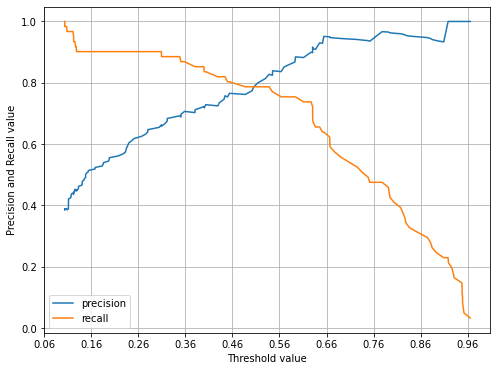

In [24]:
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
%matplotlib inline


def precision_recall_curve_plot(y_test,pred_proba_c1):
  #threshold ndarray와 이 threshold에 따른 정밀도, 재현율 ndarray 추출
  precision, recalls, thresholds=precision_recall_curve(y_test,pred_proba_c1)
  
  #x축을 threshold 값으로, y축은 정밀도,재현율 값으로 각각 plot수행, 정밀도는 점선으로 표시
  plt.figure(figsize=(8,6))
  threshold_boundary=thresholds.shape[0]
  plt.plot(thresholds,precisions[0:threshold_boundary],linestyle='-',label='precision')
  plt.plot(thresholds,recalls[0:threshold_boundary],label='recall')

  #threshold값 X축의 scale을 0.1단위로 변경
  start,end=plt.xlim()
  plt.xticks(np.round(np.arange(start,end,0.1),2))

  #x축, y축 label과 legend, 그리고 grid 설정
  plt.xlabel('Threshold value');plt.ylabel('Precision and Recall value')
  plt.legend();plt.grid()
  plt.show()

precision_recall_curve_plot(y_test,lr_clf.predict_proba(X_test)[:,1])


---
##**04. F1 스코어**

: F1 스코어(Score)는 정밀도와 재현율을 결합한 지표. 이는 정밀도와 재현율이 어느 한 쪽으로 치우치지 않는 수치를 나타낼 때 상대적으로 높은 값을 가짐.


In [26]:
from sklearn.metrics import f1_score
f1=f1_score(y_test,pred)
print('F1 score:{0:.4f}'.format(f1))

F1 score:0.7805


In [28]:
def get_clf_eval(y_test,pred):
  confusion=confusion_matrix(y_test,pred)
  accuracy=accuracy_score(y_test,pred)
  precision=precision_score(y_test,pred)
  recall=recall_score(y_test,pred)
  #F! 스코어 추가
  f1=f1_score(y_test,pred)
  print('오차 행렬')
  print(confusion)
  #f1 score print 추가
  print('정확도:{0:.4f},정밀도:{1:.4f},재현율:{2:.4f},F1:{3:.4f}'.format(accuracy,precision,recall,f1))

thresholds=[0.40,0.45,0.50,0.55,0.60]
pred_proba=lr_clf.predict_proba(X_test)
get_eval_by_threshold(y_test,pred_proba[:,1].reshape(-1,1),thresholds)

임곗값: 0.4
오차 행렬
[[98 20]
 [10 51]]
정확도:0.8324,정밀도:0.7183,재현율:0.8361,F1:0.7727
임곗값: 0.45
오차 행렬
[[103  15]
 [ 12  49]]
정확도:0.8492,정밀도:0.7656,재현율:0.8033,F1:0.7840
임곗값: 0.5
오차 행렬
[[104  14]
 [ 13  48]]
정확도:0.8492,정밀도:0.7742,재현율:0.7869,F1:0.7805
임곗값: 0.55
오차 행렬
[[109   9]
 [ 15  46]]
정확도:0.8659,정밀도:0.8364,재현율:0.7541,F1:0.7931
임곗값: 0.6
오차 행렬
[[112   6]
 [ 16  45]]
정확도:0.8771,정밀도:0.8824,재현율:0.7377,F1:0.8036



---
##**05. ROC 곡선과 AUC**

*   ROC 곡선은 우리말로 수신자 판단 곡선. FPR이 변할 때 TPR이 어떻게 변하는지를 나타내는 곡선.
*   TPR은 True Positive Rate의 약자이며, 재현율을 나타냄. 즉, 민감도로도 불림. 그리고 민감도에 대응하는 지표로 TNR이라고도 불리는 특이성(Specificity)이 있음.
*   ROC 곡선의 예에서 가운데 직선은 ROC 곡선의 최저 값. ROC 곡선이 가운데 직선에 가까울수록 성능이 떨어지는 것이며, 멀어질수록 성능이 뛰어난 것.
*   사이킷런은 ROC 곡선을 구하기 위해 roc_curve() API를 제공.
*   일반적으로 ROC 곡선 자체는 FPR과 TPR의 변화 값을 보는 데 이용하며 분류의 성능 지표로 사용되는 것은 ROC 곡선 면적에 기반한 AUC 값으로 결정. AUC 값은 ROC 곡선 밑의 면적을 구한 것으로서 일반적으로 1에 가까울수록 좋은 수치. AUC 수치가 커지려면 FPR이 작은 상태에서 얼마나 큰 TPR을 얻을 수 있느냐가 관건.




In [29]:
from sklearn.metrics import roc_curve

#레이블 값이 1일 때의 예측확률을 추출
pred_proba_class1=lr_clf.predict_proba(X_test)[:,1]

fprs,tprs,thresholds=roc_curve(y_test,pred_proba_class1)

#반환된 임계값 배열 로우가 47건이므로 샘플로 10건만 추출하되, 임계값을 5 step으로 추출
#thresholds[0]은 max(예측확률)+1로 임의 설정. 이를 제외하기 위해 np.arange는 1부터 시작
thr_index=np.arange(1,thresholds.shape[0],5)

print('샘플 추출을 위한 임곗값 배열의 index 10개:',thr_index)
print('샘플용 10개의 임곗값:',np.round(thresholds[thr_index],2))

#5 step 단위로 추출된 임계값에 따른 FPR,TPR 값
print('샘플 임곗값 별 FPR:', np.round(fprs[thr_index],3))
print('샘플 임곗값 별 TPR:',np.round(tprs[thr_index],3))

샘플 추출을 위한 임곗값 배열의 index 10개: [ 1  6 11 16 21 26 31 36 41 46 51]
샘플용 10개의 임곗값: [0.97 0.65 0.63 0.56 0.45 0.4  0.35 0.15 0.13 0.11 0.11]
샘플 임곗값 별 FPR: [0.    0.017 0.034 0.076 0.127 0.169 0.203 0.466 0.585 0.686 0.797]
샘플 임곗값 별 TPR: [0.033 0.639 0.721 0.754 0.803 0.836 0.885 0.902 0.934 0.967 0.984]


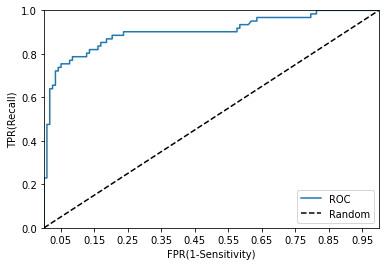

In [31]:
def roc_curve_plot(y_test, pred_proba_c1):
    #임계값에 따른 FPR, TPR 값을반환 받음
    fprs, tprs, thresholds  = roc_curve(y_test, pred_proba_c1)
    # ROC곡선을 그래프로 그림
    plt.plot(fprs, tprs, label='ROC')
    # 가운데 대각선 직선을 그림
    plt.plot([0,1], [0,1], 'k--', label='Random')
    
    # FPR X축의 Scale을 0.1 단위로 변경, X, Y축 명 설정 등
    start, end = plt.xlim()
    plt.xticks(np.round(np.arange(start, end, 0.1), 2))
    plt.xlim(0, 1)
    plt.ylim(0, 1)
    plt.xlabel('FPR(1-Sensitivity)')
    plt.ylabel('TPR(Recall)')
    plt.legend()
    
roc_curve_plot(y_test, pred_proba[:, 1])

In [32]:
def get_clf_eval(y_test, pred=None, pred_proba=None): #평가 한번에 호출하는 함수
  confusion = confusion_matrix(y_test, pred)
  accuracy = accuracy_score(y_test, pred)
  precision = precision_score(y_test, pred)
  recall = recall_score(y_test, pred)
  f1 = f1_score(y_test, pred)

  #ROC-AUC 추가
  roc_auc = roc_auc_score(y_test, pred_proba)

  print('오차행렬')
  print(confusion)
  print('정확도 : {0:.4f}, 정밀도 : {1:.4f}, 재현율:{2:.4f}, F1 : {3:.4f}, AUC : {4:.4f}'.format(accuracy, precision, recall, f1, roc_auc))